In [2]:
from fastcore.all import *
from fastai.vision.all import *

RANDOMSEED = 2001

Labels: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Lengths of datasets: training 4608 validation 1152 testing 640


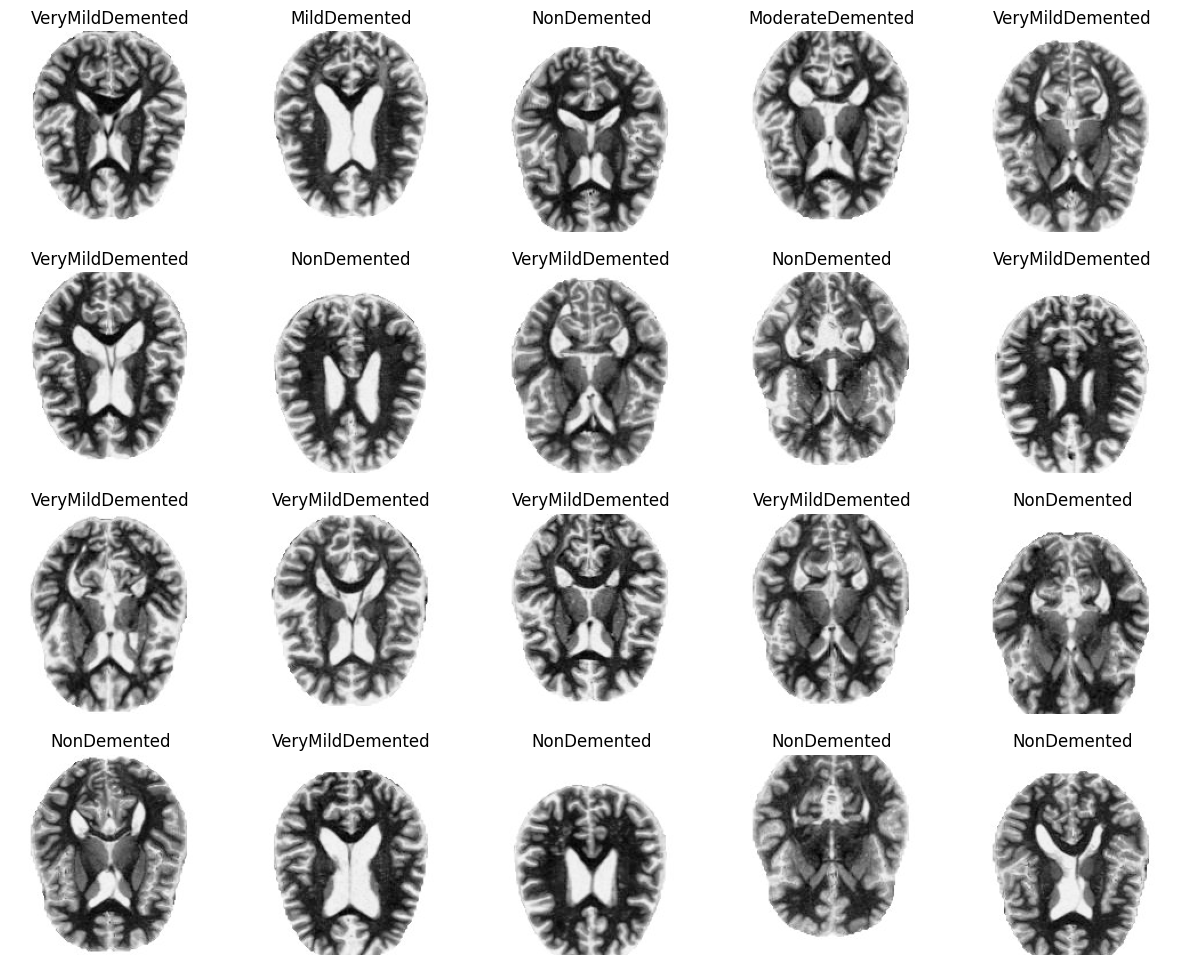

In [3]:
# Load source data from disk.

from itertools import chain 
from sklearn.model_selection import train_test_split


def split_data(path, test_size=0.1, valid_size=0.2, seed=None):
    "Split the data into train, valid, and test sets."

    if seed is None:
        seed = RANDOMSEED
        
    files = get_image_files(path)
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=seed)
    # Adjust valid_size to compensate for the reduced training set size
    valid_size_adj = valid_size / (1 - test_size)
    train_files, valid_files = train_test_split(train_files, test_size=valid_size_adj, random_state=seed)
    return train_files, valid_files, test_files


def get_dls(path, sizes=(176,), bs=64):
    train_files, valid_files, test_files = split_data(path, test_size=0.1, valid_size=0.2, seed=RANDOMSEED)  # Example splits
    dls = ImageDataLoaders.from_path_func(
        path, train_files + valid_files, img_cls=PILImageBW,
        label_func=parent_label, valid_pct=0.2, 
        seed=RANDOMSEED, item_tfms=Resize(sizes[0]), bs=bs)
    return dls, test_files


"""dls = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files, 
    splitter=splitter,
    get_y=parent_label,
    item_tfms=[Resize(176, method='squish')]
).dataloaders('dataset', bs=32)
"""


dls, test_files = get_dls('dataset')

#print(test_set)
print("Labels:", dls.vocab)
print("Lengths of datasets: training %d validation %d testing %d" % (len(dls.items), len(dls.valid_ds.items), len(test_files)))
dls.show_batch(max_n=20)


epoch,train_loss,valid_loss,error_rate,time
0,1.818621,1.129890,0.435764,00:42


epoch,train_loss,valid_loss,error_rate,time
0,1.127535,0.830702,0.328993,01:01
1,0.889992,0.764532,0.287326,01:00
2,0.606906,0.411434,0.167535,01:01
3,0.364130,0.309228,0.111979,01:01
4,0.238021,0.294978,0.101562,01:01


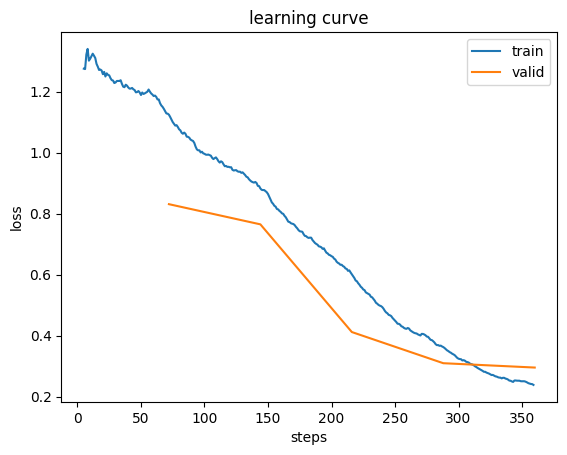

In [4]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

learn.recorder.plot_loss()
iptr = ClassificationInterpretation.from_learner(learn)

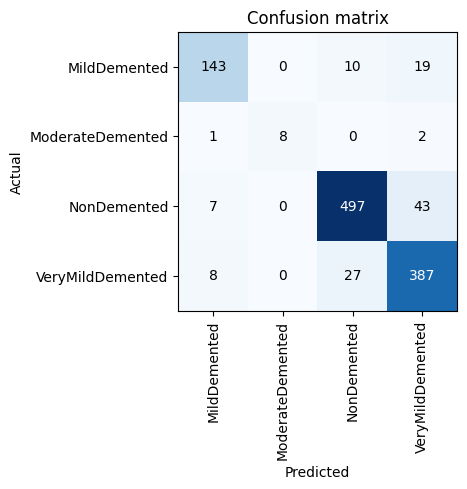

In [5]:
iptr.plot_confusion_matrix()

In [6]:

total = 0
correct = 0
misclassified = {}

with learn.no_bar():

    for i in test_files:
        total += 1
        lbl = str(i).split('/')[2]
        img = PILImageBW.create(i)
        #print(i, img)
        pred_lbl = learn.predict(img)[0]
        
        if lbl != pred_lbl:
            misclassified[(lbl, pred_lbl)] = misclassified.get((lbl, pred_lbl), 0) + 1
        else:
            correct += 1

print("Accuracy (correct/total): %.2f%%" %(float(correct * 100)/ total))
for i in misclassified:
    print("Count of %s misclassified as %s: %d" % (i[0], i[1], misclassified[i]))


Accuracy (correct/total): 88.59%
Count of NonDemented misclassified as VeryMildDemented: 29
Count of MildDemented misclassified as VeryMildDemented: 14
Count of VeryMildDemented misclassified as MildDemented: 9
Count of VeryMildDemented misclassified as NonDemented: 13
Count of NonDemented misclassified as MildDemented: 3
Count of ModerateDemented misclassified as MildDemented: 2
Count of MildDemented misclassified as NonDemented: 3


In [7]:
print(learn.model)
from torchinfo import summary

# Assuming a typical input size for an image (channels, width, height)
summary(learn.model, input_size=(1, 3, 176, 176))


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Layer (type:depth-idx)                        Output Shape              Param #
Sequential                                    [1, 4]                    --
├─Sequential: 1-1                             [1, 512, 6, 6]            --
│    └─Conv2d: 2-1                            [1, 64, 88, 88]           9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 88, 88]           128
│    └─ReLU: 2-3                              [1, 64, 88, 88]           --
│    └─MaxPool2d: 2-4                         [1, 64, 44, 44]           --
│    └─Sequential: 2-5                        [1, 64, 44, 44]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 44, 44]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 44, 44]           73,984
│    └─Sequential: 2-6                        [1, 128, 22, 22]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 22, 22]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 22, 22]          295,42

# 